## 1

In [278]:
from bs4 import BeautifulSoup
import requests
from lxml import etree
import pandas as pd

post_list = []
username_list = []
date_list = []

def get_soup(url):
    return BeautifulSoup(requests.get(url).text, "lxml")
    
#Pull in posts from the first 300 pages of forum posts
for p in range(2,300): # Didn't include page 1 for code simplicity
    url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p"+str(p)
    soup = get_soup(url)
    
    for post in soup.find_all("div", class_="Message"):
        post_list.append(post.get_text().strip().encode('utf-8'))
        
    for user in soup.find_all("span", class_="Author"):
        username_list.append(user.a["title"])

    for date in soup.find_all("span", class_="MItem DateCreated"):
        date_list.append(date.time["title"])
    if p % 10 == 0:
        print 'Scraping Page #{}'.format(p)
        
#Check number of posts included
len(post_list)

#Inspect a post
print post_list[0]
print username_list[0]
print date_list[0]

#Convert to Dataframe
posts_df = pd.DataFrame(
    {'Post': post_list,
     'User': username_list,
     'Date': date_list
    })

posts_df.to_csv('Edmunds_Posts.csv', index = False)

posts_df.head()

In [354]:
from nltk import word_tokenize

def get_targets(post, brand_dict):
    
    ''' Take individual post and return only the words that appear in the brand dictionary (brands and models) '''
    
    # Tokenize post
    tokens = word_tokenize(post)
    
    # Remove all tokens but brands and models
    targets = [word.lower() for word in tokens if word.lower() in brand_dict.keys() or word.lower() in brand_dict.values()]
    
    return targets

In [355]:
def models_to_brands(targets, brand_dict):
    
    ''' Take list of brands and models and return new list where the models are converted to their respective brands '''
    
    # Create list to store brand names
    brands = []
    
    # Iterate through words
    for word in targets:
        
        # Convert models to brands and add to brand list
        if word in brand_dict.keys():
            brands.append(brand_dict[word])
            
        # Add brands that were mentioned to list
        elif word in brand_dict.values():
            brands.append(word)
        
        else:
            continue
        
    return brands



def get_unique_brands(brand_list):
    
    ''' Take list of brands and return new list that removes duplicates '''
    
    # Create list to store unique brand names
    unique_brands = []
    
    for brand in brand_list:
        if brand not in unique_brands:
            unique_brands.append(brand)
    
    return unique_brands

In [356]:
import pandas as pd

edmunds = pd.read_csv('Edmunds_Posts.csv')
posts = edmunds['Post'].dropna().tolist()
test = posts[0:100]

In [359]:
cars = pd.read_csv('cars.csv')

makes = cars['make']
models = cars['model']

# Convert make and model strings to unicode
keys = []
values = []
for model in models:
    keys.append(unicode(model, "ISO-8859-1"))

for make in makes:
    values.append(unicode(make, "ISO-8859-1"))
    

# Create dictionary mapping models to their respective brands
brand_dict = dict(zip(keys, values))

In [360]:
import math

def count_brand_frequencies(posts, brand_dict):
    
    ''' Take list of posts and return a dictionary of frequency counts for each brand that was mentioned '''
    
    # Initialize frequency dictionary
    brand_counts = {}
    
    # Iterate through posts
    for post in posts:
        
        post = post.decode("utf8")
        
        # Retrieve brand names and models from post
        targets = get_targets(post, brand_dict)
        
        # Create list of brands that were mentioned in post (models converted to respective brands)
        brands = models_to_brands(targets, brand_dict)
        
        # Retrieve only unique brand names from list of brands that were mentioned
        unique_brands = get_unique_brands(brands)
        
        # Add each brand that was mentioned to total brand count
        for brand in unique_brands:
            if brand not in brand_counts.keys():
                brand_counts[brand] = 1
            else:
                brand_counts[brand] += 1
    
    return brand_counts

In [361]:
brand_frequencies = count_brand_frequencies(posts, brand_dict)
brand_frequencies
df_brand_frequencies = pd.DataFrame(brand_frequencies.items(), columns=['brand','frequency'])
df_brand_frequencies = df_brand_frequencies.sort_values(by='frequency', ascending=False).reset_index().drop('index', axis=1)
df_brand_frequencies

,brand,frequency
0,bmw,2669
1,audi,776
2,acura,665
3,infiniti,597
4,honda,515
5,toyota,402
6,nissan,387
7,volvo,290
8,cadillac,265
9,volkswagen,259


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<Container object of 28 artists>

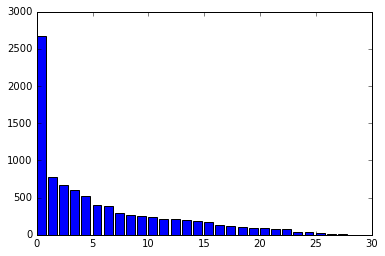

In [362]:
%pylab inline
bar(df_brand_frequencies.index, df_brand_frequencies['frequency'])

In [363]:
from nltk.corpus import stopwords
import string

def get_attribute_targets(post, brand_dict):
    
    ''' Take individual post and return only the words that are not brand/model and not stopwords '''
    
    punctuations = list(string.punctuation)
    
    # Tokenize post    
    tokens = word_tokenize(post)
    
    # Remove stop words and punctuation
    targets = [word.lower() for word in tokens if word.lower() not in stopwords.words('english') and word.lower() not in ["cars","car", "like","one","would"]]
    #targets_punct = [word.lower() for word in targets if word.lower() not in punctuations] 
    targets_punct = [word.lower() for word in targets if word.lower().isalpha()] 
    
    # Remove brands and models
    targets_final = [word.lower() for word in targets_punct if word.lower() not in brand_dict.keys() and word.lower() not in brand_dict.values()]
    
    return targets_final

In [364]:
def words_to_attributes(targets, attribute_dict):
    ''' Take list of tokenized words and return a list with targets replaced with attributes'''
    
    # Create a list of tokens converted to attributes
    tokens = []
    
    # Iterate through words
    for word in targets:
        
        # Convert words to attributes and add to tokens list
        if word in attribute_dict.keys():
            tokens.append(attribute_dict[word])
        
        # Add all other words un-converted
        else:
            tokens.append(word)
    
    return tokens

In [365]:
def count_attribute_frequencies(posts, brand_dict, attribute_dict):
    ''' Take list of posts and return a dictionary of frequency counts for each non-brand that was mentioned '''
    
    # Initialize frequency dictionary
    word_counts = {}
    
    # Iterate through posts
    for post in posts:
        
        post = post.decode("utf8")
        
        # Retrieve attribute tokens from post
        targets = get_attribute_targets(post, brand_dict)
        
        # Create list of attributes (converted rom list), continue if none provided
        if len(attribute_dict.keys())>0:
            attributes = words_to_attributes(targets, attribute_dict)
        else:
            attributes = targets
        
        # Retrieve only unique tokens from list that were mentioned
        unique_tokens = get_unique_brands(attributes)
        
        # Add each token that was mentioned to total token count
        for token in unique_tokens:
            if token not in word_counts.keys():
                word_counts[token] = 1
            else:
                word_counts[token] += 1
                
    return word_counts

In [366]:
attributes = pd.read_csv('AttributesMap.csv')

words = attributes['word']
categories = attributes['category']

# Convert words and category strings to unicode
keys = []
values = []
for word in words:
    keys.append(unicode(word, "ISO-8859-1"))

for cat in categories:
    values.append(unicode(cat, "ISO-8859-1"))

# Create dictionary mapping words to their respective categories
attribute_dict = dict(zip(keys, values))

In [367]:
attribute_frequencies_convert = count_attribute_frequencies(posts, brand_dict, attribute_dict)
attribute_frequencies_convert

{u'convolute': 1,
 u'unscientific': 1,
 u'finessed': 1,
 u'awdrl': 1,
 u'seatsare': 1,
 u'yellow': 9,
 u'four': 99,
 u'rocketing': 1,
 u'woods': 11,
 u'verses': 1,
 u'hanging': 8,
 u'onlder': 1,
 u'genre': 5,
 u'transferrable': 1,
 u'marching': 1,
 u'increase': 74,
 u'headand': 1,
 u'eligible': 2,
 u'snowing': 4,
 u'hordes': 1,
 u'objection': 1,
 u'wizardry': 2,
 u'exclusivly': 1,
 u'fingernails': 1,
 u'outwit': 1,
 u'turbodiesel': 7,
 u'underdogs': 1,
 u'screamers': 1,
 u'lord': 6,
 u'immature': 1,
 u'sprintsyet': 1,
 u'founding': 1,
 u'sinking': 3,
 u'inclement': 3,
 u'digit': 2,
 u'navigating': 1,
 u'regional': 2,
 u'deadining': 1,
 u'fwr': 1,
 u'hdtv': 2,
 u'replaces': 4,
 u'tantalizing': 1,
 u'foul': 4,
 u'classifications': 1,
 u'screaming': 12,
 u'markers': 3,
 u'advices': 1,
 u'wooded': 1,
 u'basics': 1,
 u'internally': 2,
 u'prize': 6,
 u'vibrational': 1,
 u'wooden': 1,
 u'synergy': 1,
 u'distate': 3,
 u'niceities': 1,
 u'wednesday': 5,
 u'piling': 1,
 u'oooo': 1,
 u'woudnt': 1

In [368]:
df_attribute_frequencies_convert = pd.DataFrame(attribute_frequencies_convert.items(), columns=['attribute','frequency'])

# Sort by frequency
df_attribute_frequencies_convert = df_attribute_frequencies_convert.sort_values(by='frequency', ascending=False).reset_index().drop('index', axis=1)

# Select top 5 most frequent
attribute_top_5 = df_attribute_frequencies_convert.ix[:4]['attribute']
attribute_top_5

0    performance
1         luxury
2         design
3          value
4        options
Name: attribute, dtype: object

In [369]:
list_top_brands=df_brand_frequencies['brand'].values[:10]

In [370]:
def get_brand_pairs(list_top_brands):
    ''' Takes list of top brands and generates list of brands and brand pairs '''
    
    # Initialize list of brand pairs with list of brands
    brand_dict=dict(zip(range(len(list_top_brands)),sorted(list_top_brands)))
    brand_pairs=sorted(list_top_brands)
    
    # Add brand pairs to the list
    for i, brand in enumerate(brand_pairs):
        if i<len(brand_pairs):
            n=i
            while n+1 in brand_dict.keys():
                brand_pairs.append(''.join([brand_dict[i],"_",brand_dict[n+1]]))
                n+=1
    
    return brand_pairs


def get_brand_and_pair_counts(list_top_brands, posts):
    ''' Takes list of top brands and brand pairs and returns counts and co-occurence counts'''
    
    # Create dictionary with starting 0 counts for each brand / brand pair
    top_brand_pairs=get_brand_pairs(list_top_brands)
    dict_brand_pair_counts=dict(zip(top_brand_pairs,[0]*len(top_brand_pairs)))
    
    # Process each post
    for post in posts:
        post = post.decode("utf8")

        # Retrieve brand names and models from post
        targets = get_targets(post, brand_dict)

        # Create list of brands that were mentioned in post (models converted to respective brands)
        brands = models_to_brands(targets, brand_dict)

        # Retrieve only unique brand names from list of brands that were mentioned
        unique_brands = sorted(get_unique_brands(brands))

        # Update dictionary with brand and brand pair counts
        for i,brand in enumerate(unique_brands):
            if brand in dict_brand_pair_counts.keys():
                dict_brand_pair_counts[brand]+=1
                if i<len(unique_brands):
                    n=i
                    while n+1<len(unique_brands):
                        n+=1
                        if unique_brands[n] in dict_brand_pair_counts.keys():
                            dict_brand_pair_counts[''.join([unique_brands[i],"_",unique_brands[n]])]+=1
        
    return dict_brand_pair_counts

In [411]:
def get_brand_lift_calculations(list_top_brands, posts):
    ''' Given list of brands, calculate lift ratios for associations between the brands in a set of posts '''
    
    # Get dictionary of counts for each brand and co-occurence
    counts = get_brand_and_pair_counts(list_top_brands,posts)
    tot_posts=len(posts)
    
    # Calculate lift    
    top_brands = sorted(list_top_brands)
    lift_dict={}
    for i, brand in enumerate(top_brands):
        brand_lifts=[]
        for n in range(len(top_brands)):
            if n<i:
                brand_lifts.append('')
            elif n==i:
                brand_lifts.append(float("inf"))
            elif n>i:
                compare_brand=top_brands[n]
                lift_calc=(tot_posts*counts[brand+'_'+compare_brand]*1.)/(counts[brand]*counts[compare_brand])
                brand_lifts.append(lift_calc)
        lift_dict[brand]=brand_lifts
    
    return lift_dict

def print_brand_lift_calculations(list_top_brands, posts):
    ''' PRINTED VERSION -- Given list of brands, calculate lift ratios for associations between the brands in a set of posts '''
    
    # Get dictionary of counts for each brand and co-occurence
    counts = get_brand_and_pair_counts(list_top_brands,posts)
    tot_posts=len(posts)
    
    # Tokenize post    
    top_brands = sorted(list_top_brands)
    for i, brand in enumerate(top_brands):
        if i<len(top_brands):
            n=i
            while n+1<len(top_brands):
                n+=1
                print '\n----------',top_brands[i],'and',top_brands[n],'----------'
                print top_brands[i]+':', counts[brand]
                print top_brands[n]+':', counts[top_brands[n]]
                print 'both:', counts[top_brands[i]+'_'+top_brands[n]]
                lift=(tot_posts*counts[top_brands[i]+'_'+top_brands[n]]*1.)/(counts[brand]*counts[top_brands[n]])
                print 'lift:',lift

In [412]:
lift_calculations=get_brand_lift_calculations(list_top_brands, posts)

In [404]:
df_lift_calculations=pd.DataFrame(lift_calculations,index=sorted(list_top_brands))
#df_lift_calculations.to_csv('lift.csv')

In [418]:
for i in df_lift_calculations.columns:
    for j in df_lift_calculations.index.values:
        if df_lift_calculations[i][j]=='':
            df_lift_calculations[i][j] = df_lift_calculations[j][i]
df_lift_calculations

C:\Users\anura\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,acura,audi,bmw,cadillac,honda,infiniti,nissan,toyota,volkswagen,volvo
acura,inf,2.334586466,1.588826318,3.240947652,2.918426162,4.338313119,2.288605234,2.036299704,1.86526548,2.591361162
audi,2.3345864662,inf,1.615773698,2.820754717,1.630097087,2.369346734,1.366925065,1.287313433,3.907335907,3.806896552
bmw,1.5888263183,1.615773698,inf,1.892589267,1.227059333,1.814603177,1.08860561,1.33077587,1.355503124,1.418136717
cadillac,3.2409476521,2.820754717,1.892589267,inf,1.765510167,2.98961474,1.479284286,1.675396602,1.820295767,1.974079375
honda,2.9184261625,1.630097087,1.227059333,1.765510167,inf,1.335167748,4.611886305,6.508834468,2.876875211,2.74860395
infiniti,4.3383131195,2.369346734,1.814603177,2.98961474,1.335167748,inf,2.781036968,1.26426494,1.904580819,1.855622942
nissan,2.2886052340,1.366925065,1.08860561,1.479284286,4.611886305,2.781036968,inf,4.761026907,3.205171949,2.544488996
toyota,2.0362997045,1.287313433,1.33077587,1.675396602,6.508834468,1.26426494,4.761026907,inf,2.228471542,2.908835135
volkswagen,1.8652654803,3.907335907,1.355503124,1.820295767,2.876875211,1.904580819,3.205171949,2.228471542,inf,2.495060578
volvo,2.5913611615,3.806896552,1.418136717,1.974079375,2.74860395,1.855622942,2.544488996,2.908835135,2.495060578,inf


In [420]:
df_lift_calculations_inverted = pd.DataFrame()
df_lift_calculations_inverted.set_index = df_lift_calculations.index.values
for i in df_lift_calculations.columns:
    df_lift_calculations_inverted[i] = 1/df_lift_calculations[i]
df_lift_calculations_inverted    

,acura,audi,bmw,cadillac,honda,infiniti,nissan,toyota,volkswagen,volvo
acura,0.0000000000,0.4283413849,0.629395415,0.3085517285,0.342650437,0.2305043395,0.4369473534,0.4910868463,0.536116714,0.3858975796
audi,0.4283413849,0,0.6188985507,0.3545150502,0.6134603931,0.4220572641,0.7315689981,0.7768115942,0.2559288538,0.2626811594
bmw,0.6293954150,0.6188985507,0,0.5283766622,0.814956517,0.5510846739,0.9186063264,0.751441338,0.7377334529,0.7051506306
cadillac,0.3085517285,0.3545150502,0.5283766622,0,0.5664085197,0.3344912595,0.6760025839,0.5968735993,0.549361273,0.5065652438
honda,0.3426504370,0.6134603931,0.814956517,0.5664085197,0,0.7489695594,0.2168310175,0.1536373378,0.3475993662,0.363821059
infiniti,0.2305043395,0.4220572641,0.5510846739,0.3344912595,0.7489695594,0,0.359578104,0.790973449,0.5250499165,0.5389025848
nissan,0.4369473534,0.7315689981,0.9186063264,0.6760025839,0.2168310175,0.359578104,0,0.2100387205,0.3119957418,0.3930062192
toyota,0.4910868463,0.7768115942,0.751441338,0.5968735993,0.1536373378,0.790973449,0.2100387205,0,0.4487380616,0.343780226
volkswagen,0.5361167140,0.2559288538,0.7377334529,0.549361273,0.3475993662,0.5250499165,0.3119957418,0.4487380616,0,0.4007918721
volvo,0.3858975796,0.2626811594,0.7051506306,0.5065652438,0.363821059,0.5389025848,0.3930062192,0.343780226,0.4007918721,0


In [374]:
print_brand_lift_calculations(list_top_brands,posts)


---------- acura and audi ----------
acura: 665
audi: 776
both: 135
lift: 2.33458646617

---------- acura and bmw ----------
acura: 665
bmw: 2669
both: 316
lift: 1.58882631832

---------- acura and cadillac ----------
acura: 665
cadillac: 265
both: 64
lift: 3.24094765215

---------- acura and honda ----------
acura: 665
honda: 515
both: 112
lift: 2.91842616249

---------- acura and infiniti ----------
acura: 665
infiniti: 597
both: 193
lift: 4.33831311948

---------- acura and nissan ----------
acura: 665
nissan: 387
both: 66
lift: 2.28860523402

---------- acura and toyota ----------
acura: 665
toyota: 402
both: 61
lift: 2.03629970449

---------- acura and volkswagen ----------
acura: 665
volkswagen: 259
both: 36
lift: 1.8652654803

---------- acura and volvo ----------
acura: 665
volvo: 290
both: 56
lift: 2.59136116152

---------- audi and bmw ----------
audi: 776
bmw: 2669
both: 375
lift: 1.61577369801

---------- audi and cadillac ----------
audi: 776
cadillac: 265
both: 65
lift: 

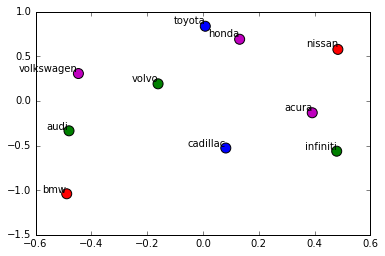

In [450]:
from sklearn.manifold import MDS

mds = MDS()

mds_fit = mds.fit_transform(df_lift_calculations_inverted)

x=[]
y=[]
for i in range(len(mds_fit)):
    x.append(mds_fit[i][0])
for j in range(len(mds_fit)):
    y.append(mds_fit[j][1])
    
print x,y


labels = df_lift_calculations.index.values

plt.scatter(x,y, s=100 ,marker='o')
for label,x,y in zip(labels,x,y):
    plt.annotate(label,xy=(x,y),textcoords='offset points', ha='right', va='bottom')
plt.show()

In [451]:
top_5_brands=list_top_brands[:5]
dict_top_5_brands_freq=dict(zip(list(df_brand_frequencies['brand'][:5]),list(df_brand_frequencies['frequency'][:5])))

# Get top 5 attributes counts
dict_top_5_attributes_freq=dict(zip(list(df_attribute_frequencies_convert['attribute'][:5]),list(df_attribute_frequencies_convert['frequency'][:5])))

In [452]:
def tokenize_post_for_brand_and_attributes(post,top_5_list):  
    ''' Tokenizes posts and returns unique instances of top 5 brands / attributes '''

    # Tokenize post
    post = post.decode("utf8")
    tokens = word_tokenize(post)

    # Remove stop words and punctuation
    targets = [word.lower() for word in tokens if word.lower() not in stopwords.words('english') and word.lower() not in ["cars","car", "like","one","would"]]
    targets_punct = [word.lower() for word in targets if word.lower().isalpha()] 

    # Return unique list of brands and models
    targets_final = [word.lower() for word in targets_punct if word.lower() in top_5_list]
    unique_brands_and_attributes=list(set(targets_final))
    
    return unique_brands_and_attributes 

def get_brand_and_attribute_counts(brands_list, attributes_list, posts):
    ''' Given lists of brands and attributes, calculate co-occurences in a set of posts '''
    
    # Set up dictionary of counts for each brand/attribute pair combination
    brands=brands_list
    attributes=attributes_list
    top_5_list=brands+attributes
    brand_attributes_pairs={}
    for brand in brands:
        brand_attributes_pairs[brand]=dict(zip(attributes,[0]*5))

    # Get counts by brand for co-occurence with each attribute
    for post in posts:
        post_tokens=tokenize_post_for_brand_and_attributes(post,top_5_list)
        for brand in brands:
            if brand in post_tokens:
                for attribute in attributes:
                    if attribute in post_tokens:
                        brand_attributes_pairs[brand][attribute]+=1
    
    return brand_attributes_pairs

In [453]:
def get_attribute_lift_calculations(top_5_brands_freqdict, top_5_attributes_freqdict, posts):
    ''' Given lists/freqencies of brands and attributes, calculate lift ratios for associations between the brands and attributes in a set of posts '''
    
    # Get dictionary of counts for each brand/attribute pair combination
    brands=top_5_brands_freqdict.keys()
    attributes=top_5_attributes_freqdict.keys()
    counts = get_brand_and_attribute_counts(brands, attributes, posts)
    tot_posts=len(posts)
    
    # Calculate lift    
    lift_dict={}
    
    for attribute in attributes:
        attributebrand_lifts=[]
        for brand in brands:
            lift_calc=(tot_posts*counts[brand][attribute]*1.)/(top_5_brands_freqdict[brand]*top_5_attributes_freqdict[attribute])
            attributebrand_lifts.append(lift_calc)
        lift_dict[attribute]=attributebrand_lifts
    
    return lift_dict

In [454]:
# Get lift ratios for brands and attributes
brandattribute_lift_calculations=get_attribute_lift_calculations(dict_top_5_brands_freq,dict_top_5_attributes_freq,posts)

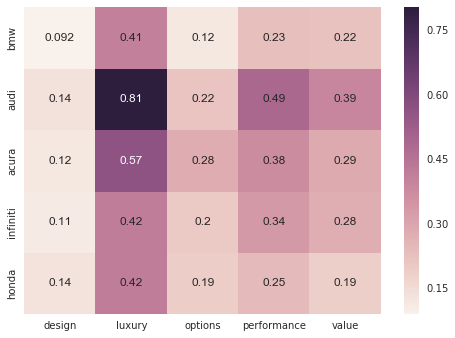

In [456]:
import seaborn as sns

# Show lift ratios for brands and attributes in a table
df_brandattribute_lift_calculations=pd.DataFrame(brandattribute_lift_calculations,index=top_5_brands)
#df_brandattribute_lift_calculations

sns.heatmap(df_brandattribute_lift_calculations,annot = True)